In [15]:
"""
Homecare vehicule routing problem with time windows constraint
By Prof LAYEB abdesslem university of constantine 2, LISIA laboratory 
abdesslem.layeb@univ-constantine2.dz

"""
import numpy as np
import pandas as pd
from pyomo.environ import *
import itertools
import osmnx
import folium
import warnings
warnings.filterwarnings("ignore")


# Load constantine map
# Load distance times and speeds between every edges

In [37]:
place_name = 'constantine,algeria'
# Fetch OSM street network from the location
G = osmnx.graph_from_place(place_name)

# Check data type of the graph 
#type(G) 

#DiGraph is a data type that stores nodes and edges with optional data, or attributes.
# Plot the streets
#fig, ax = osmnx.plot_graph(G)

# impute speed on all edges missing data
G = osmnx.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = osmnx.add_edge_travel_times(G)

# DATA problem 

In [29]:
# patient count ('0' is Hospital) 
patient_count =12

# the number of Ambulance
max_Ambulance_count = 20


# the nursing time
nursing_time=3  # in hours

# the working time of an Ambulance
# Ambulance_time=6 # in hours

# minimum number of patients to be served
minpatients=3

# fix random seed
np.random.seed(seed=777)

# find the coordinate of Chu CONSTANTINE
address1='CHU constantine'
origin_coordinates=osmnx.geocode(address1)

# set Hospital latitude and longitude
Hospital_latitude = origin_coordinates[0]
Hospital_longitude = origin_coordinates[1]

# find the colosest node to CHU constantine Coordinate
origin_node =osmnx.get_nearest_node (G, origin_coordinates,method='haversine')

# create random patient locations
import random
nodes_id = list(G.nodes)
#we use this list to get non-repeating elemets
nodes_patients=random.sample(nodes_id,patient_count)

nodes_patients[0]=origin_node

df = pd.DataFrame(index =range(patient_count),columns =["latitude", "longitude"])

for i in range(patient_count):
    df.iloc[i,0] =G.nodes[nodes_patients[i]]['y']
    df.iloc[i,1] =G.nodes[nodes_patients[i]]['x']
    
# df.iloc[0,0] = G.nodes[origin_node]['y']
# df.iloc[0,1]= G.nodes[origin_node]['x']

In [30]:
print("The locations of patients")
print(" ")
print(df)

The locations of patients
 
     latitude longitude
0   36.373717  6.616686
1   36.355521  6.641424
2   36.362412  6.644491
3   36.354873  6.591494
4   36.344723  6.595027
5   36.359667  6.595361
6   36.307014  6.681709
7   36.351179  6.625297
8   36.366486   6.63313
9   36.348576  6.652694
10  36.370982  6.622073
11  36.315909  6.604764


## Compute travel time distances

In [31]:
# get travel time between two patients

distance = np.zeros((patient_count,patient_count))


# for j in range (1,patient_count+1):
#     route1 = osmnx.shortest_path(G, origin_node, nodes_patients[j-1], weight="travel_time")
#     timesnodes[str((0,j))]=round(sum(osmnx.utils_graph.get_route_edge_attributes(G, route1, 'travel_time'))/60)
        
for i in range(0,patient_count):
    for j in range (i+1,patient_count):
        
        try:
            route1 = osmnx.shortest_path(G, nodes_patients[i], nodes_patients[j], weight="travel_time")
            distance[i][j]=(sum(osmnx.utils_graph.get_route_edge_attributes(G, route1, 'travel_time'))/3600)
        except:
             distance[i][j]=1000000000
        
        
        distance[j][i]=distance[i][j]
        
# multiply by trafic weight
distance=1.8*distance
distance

array([[0.     , 0.21105, 0.16925, 0.23185, 0.26165, 0.19435, 0.40365,
        0.1813 , 0.1796 , 0.2871 , 0.0677 , 0.36055],
       [0.21105, 0.     , 0.04875, 0.25255, 0.2797 , 0.24815, 0.3047 ,
        0.11995, 0.1011 , 0.1176 , 0.17495, 0.30365],
       [0.16925, 0.04875, 0.     , 0.2587 , 0.28585, 0.24955, 0.3061 ,
        0.1261 , 0.0748 , 0.12815, 0.14465, 0.3098 ],
       [0.23185, 0.25255, 0.2587 , 0.     , 0.04945, 0.0465 , 0.39025,
        0.14625, 0.28905, 0.2737 , 0.22065, 0.2134 ],
       [0.26165, 0.2797 , 0.28585, 0.04945, 0.     , 0.1031 , 0.391  ,
        0.147  , 0.2898 , 0.27445, 0.2299 , 0.21545],
       [0.19435, 0.24815, 0.24955, 0.0465 , 0.1031 , 0.     , 0.42605,
        0.18205, 0.2799 , 0.3095 , 0.17415, 0.2562 ],
       [0.40365, 0.3047 , 0.3061 , 0.39025, 0.391  , 0.42605, 0.     ,
        0.2288 , 0.3113 , 0.20645, 0.33095, 0.359  ],
       [0.1813 , 0.11995, 0.1261 , 0.14625, 0.147  , 0.18205, 0.2288 ,
        0.     , 0.14695, 0.1316 , 0.14575, 0.22415],


## Compute health service time  (service time)     

In [32]:
# compute health service time  (service time)          
import random
listeTH=range(15, 60, 5)
TH=[0]*(patient_count)
for i in range (patient_count):
    TH[i]= random.choice(listeTH)/60
TH[0]=0
TH=[round(item, 2) for item in TH]
print("the health service time for each patient is (in hours)")
print(TH)

the health service time for each patient is (in hours)
[0, 0.83, 0.58, 0.67, 0.75, 0.75, 0.42, 0.75, 0.5, 0.58, 0.5, 0.58]


## Add time windows: Earliest Time, Latest time  for each patient

In [33]:
# add time windows

TMW = {"Earliest Time": np.random.randint(7, 11, patient_count), "Latest time": np.random.randint(12, 15, patient_count),
       "Service Time": np.array(TH)}  # Earliest time, latest time and service time at client i
#chu
TMW["Earliest Time"][0]=7
TMW["Latest time"][0]=15
print( "time windows and service tim for each patient")
print('Earliest Time',TMW['Earliest Time'])
print('Latest time',TMW['Latest time'])
print('Service Time',TMW['Service Time'])

time windows and service tim for each patient
Earliest Time [ 7 10 10  9 10  8 10  8 10  7 10  8]
Latest time [15 14 12 14 13 14 12 13 14 12 13 13]
Service Time [0.   0.83 0.58 0.67 0.75 0.75 0.42 0.75 0.5  0.58 0.5  0.58]


# create and solve the model

In [34]:
#create model
for Ambulance_count in range(1,max_Ambulance_count):

    model = ConcreteModel()

   # model.distance=distance
    # solve with pyomo

   
    model.patient = Set(initialize=range(patient_count))
    model.Ambulances = Set(initialize=range(Ambulance_count))
    
    model.x = Var(
             model.patient,model.patient, model.Ambulances,
             within=Binary,
            doc="1 if taken route from i-th to j-th place taken by k-th Ambulance, 0 otherwise"
             )
    # add objective function

    
    model.obj_total_cost = Objective(
            sense=minimize,
            expr=(sum(
                 distance[i, j] * model.x[i, j, k]
                for i in range(patient_count)
                for j in range(patient_count) if j != i
                for k in range(Ambulance_count))+
                  sum(TH[j] * model.x[i, j, k] if i != j else 0 
                         for i in range(patient_count) for j in range (1,patient_count) for k in range(Ambulance_count))
            ),
            doc="Minimize total cost of routes taken by Ambulances"
        )

    # constraints
    # one patient is served by one ambulance
    model.c=ConstraintList()
    for j in range( 1,patient_count):
        model.c.add(sum(model.x[i, j, k] if i != j else 0 
                              for i in range(patient_count) 
                              for k in range(Ambulance_count)) == 1)

    # departure and arrivals of each ambulance from hospital
    for k in range(Ambulance_count):
        model.c.add(sum(model.x[0, j, k] for j in range(1,patient_count)) == 1)
        model.c.add(sum(model.x[i, 0, k] for i in range(1,patient_count)) == 1)

  # the number of vehicles coming in and out of a customer’s location is the same
    for k in range(Ambulance_count):
        for j in range(patient_count):
             model.c.add(sum(model.x[i, j, k] if i != j else 0 
                                  for i in range(patient_count)) -  sum(model.x[j, i, k] 
                                                                         for i in range(patient_count)) == 0)

     # respect nursing time
    for k in range(Ambulance_count):
         model.c.add(sum(TH[j] * model.x[i, j, k] if i != j else 0 
                         for i in range(patient_count) for j in range (1,patient_count)) <= nursing_time) 
    

    # equitable service: Ambulance serves >n patients
    for k in range(Ambulance_count):            
        model.c.add(  sum(model.x[i, j, k] if i != j else 0 
                for i in range(patient_count)
                for j in range(patient_count) ) >=minpatients+1)
        
    # subtours elimination constraint
    subtours = []
    for i in range(2,patient_count):
         subtours += itertools.combinations(range(1,patient_count), i)

    for s in subtours:
         model.c.add(sum(model.x[i, j, k] if i !=j else 0 for i, j in itertools.permutations(s,2) 
                         for k in range(Ambulance_count)) <= len(s) - 1)
 #time windows  handling

    model.Starting_Time= Var(
             model.Ambulances, model.patient,
             within=NonNegativeReals,
            doc="1 if , 0 otherwise")
    
    for i in range(patient_count):
        for j in range (1,patient_count): 
            for k in range(Ambulance_count):
                if i!=j :
                    model.c.add(  model.Starting_Time[k,i] + distance[i, j]  + TMW["Service Time"][i] - (
                         TMW["Latest time"][i] + distance[i, j] - TMW["Earliest Time"][i]) * (1 - model.x[i, j, k] ) <= model.Starting_Time[k,j] )           
    
  
     
    for k in range(Ambulance_count):
        for i in range(patient_count):
            model.c.add(  model.Starting_Time[k,i]<=TMW["Latest time"][i])
            model.c.add(  model.Starting_Time[k,i]>=TMW["Earliest Time"][i])
            model.c.add(  (model.Starting_Time[k,i]+TMW["Service Time"][i] +distance[i,0])<=TMW["Latest time"][0]) # don't depass  chu  return time

# second version  tw contraint
#     pt=range(patient_count)
#     pt1=range(1,patient_count)
    
#     Routes=[(i, j) for i in pt for j in pt1 if i != j]
    
#     for k in range(Ambulance_count):
#         for (i, j) in Routes:
#              model.c.add( model.Starting_Time[k,j] - model.Starting_Time[k,i] - 
#                          (TMW["Service Time"][i] +distance[i, j])*model.x[i, j, k] + 
#                          max(0,TMW["Latest time"][i] + TMW["Service Time"][i]+distance[i, j] - TMW["Earliest Time"][i]) * (1 - model.x[i, j, k] ) >=0 )    
             
## third version TW contraint

#     for i in range(patient_count):
#         for j in range (1,patient_count): 
#             for k in range(Ambulance_count): 
#                 if i!=j:
#                     model.c.add( model.Starting_Time[k,i]+TMW["Service Time"][i] +distance[i, j]-(1-model.x[i,j,k])*10000000<=model.Starting_Time[k,j]   )
        
      
    # IBM cplex solver
    solver = SolverFactory('cplex')
    #solver = SolverFactory('glpk') # another solver
    result = solver.solve(model,tee=False)   
   
    
# mtz formulation
#     model.u =  Var( model.patient,bounds=(TH[i],nursing_time))
#     model.u[0].setlb(0)
#     model.u[0].setub(0)
#     for i in range(1,patient_count) :
#         model.u[i].setlb(TH[i])
#         for k in range (Ambulance_count):
#             for i in range(patient_count) :
#                 for j in range(1,patient_count) :
#                      model.c.add( model.u[i] - model.u[j] + nursing_time * model.x[i,j,k] <= nursing_time- TH[j] )

    # print Ambulance_count which needed for solving problem
    # print calculated minimum distance value
    

    if  (result.solver.status == SolverStatus.ok) and (result.solver.termination_condition == TerminationCondition.optimal):
            break;

            
            #     for k in range(Ambulance_count):
#         for i in range(patient_count):
#             for j in range(1,patient_count):
#                 if i!=j :
#                     model.c.add(  model.Starting_Time[k,i] + distance[i, j]  + TMW["Service Time"][i] - (
#                          TMW["Latest time"][i] + distance[i, j] - TMW["Earliest Time"][i]) * (1 - model.x[i, j, k] ) <= model.Starting_Time[k,j] )           
    
  

# display solution

In [35]:
#display solution
print("number of used Ambulances:",Ambulance_count)
List = list(model.x.keys())
for i in List:
    if model.x[i]() ==1:
        print(i,'--', model.x[i]())
        
List = list(model.Starting_Time.keys())  
for i in List:
    
        print(i,'--', model.Starting_Time[i]())
        


number of used Ambulances: 3
(0, 2, 2) -- 1.0
(0, 5, 0) -- 1.0
(0, 7, 1) -- 1.0
(1, 0, 1) -- 1.0
(2, 8, 2) -- 1.0
(3, 4, 0) -- 1.0
(4, 11, 0) -- 1.0
(5, 3, 0) -- 1.0
(6, 9, 1) -- 1.0
(7, 6, 1) -- 1.0
(8, 10, 2) -- 1.0
(9, 1, 1) -- 1.0
(10, 0, 2) -- 1.0
(11, 0, 0) -- 1.0
(0, 0) -- 7.0
(0, 1) -- 10.0
(0, 2) -- 10.0
(0, 3) -- 9.5465
(0, 4) -- 10.26595
(0, 5) -- 8.75
(0, 6) -- 10.0
(0, 7) -- 13.0
(0, 8) -- 10.0
(0, 9) -- 8.75
(0, 10) -- 10.0
(0, 11) -- 11.2314
(1, 0) -- 7.0
(1, 1) -- 12.6976
(1, 2) -- 11.81475
(1, 3) -- 10.39475
(1, 4) -- 10.39475
(1, 5) -- 10.39475
(1, 6) -- 11.37355
(1, 7) -- 10.39475
(1, 8) -- 10.39475
(1, 9) -- 12.0
(1, 10) -- 10.39475
(1, 11) -- 10.39475
(2, 0) -- 7.0
(2, 1) -- 10.0
(2, 2) -- 10.0
(2, 3) -- 9.0
(2, 4) -- 11.056750000000001
(2, 5) -- 8.806750000000001
(2, 6) -- 10.386750000000001
(2, 7) -- 8.806750000000001
(2, 8) -- 10.6548
(2, 9) -- 12.000000000000007
(2, 10) -- 11.306750000000001
(2, 11) -- 8.806750000000001


In [23]:
non_zero_edges = [ e for e in model.x if value(model.x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges
tours = get_next_site(0)
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !=0:
        t.append(get_next_site(t[-1][1])[-1])
        
#print routes        
for t in tours:
    k=t[0][2]
    print("vehicle_count:",k)
    print(0,' ->',end = '')
    for i in range (1,np.shape(t)[0]):
         print(t[i][0],'(',value(model.Starting_Time[k,t[i][0]]),'h)', '-> ', end = '')
         if i==np.shape(t)[0]-1:
            print(0)

vehicle_count: 1
0  ->2 ( 10.27045 h) -> 4 ( 11.0906 h) -> 9 ( 12.0 h) -> 0
vehicle_count: 0
0  ->6 ( 10.000000000000002 h) -> 8 ( 10.692200000000001 h) -> 1 ( 11.293450000000002 h) -> 0
vehicle_count: 2
0  ->10 ( 10.0 h) -> 11 ( 10.7782 h) -> 7 ( 11.501249999999999 h) -> 5 ( 12.007099999999998 h) -> 3 ( 13.062849999999997 h) -> 0


## visualisation : plotting with matplolib

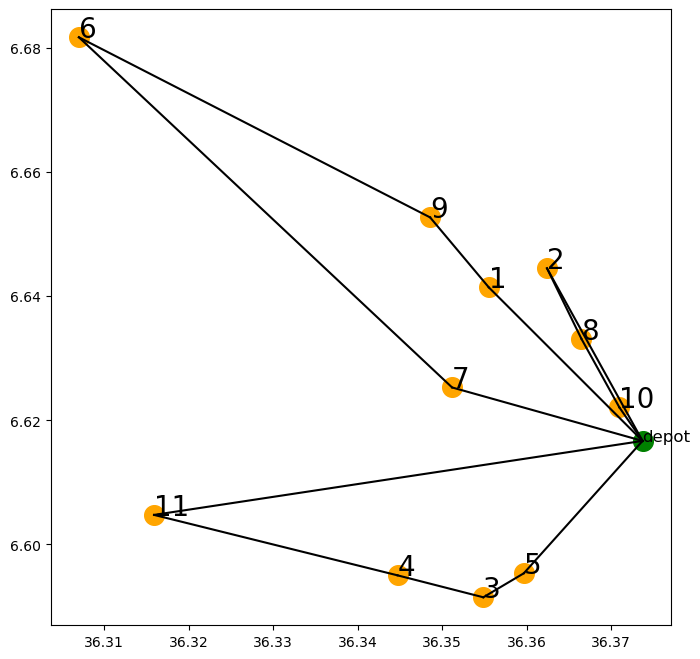

In [36]:
#visualisation : plotting with matplolib
import matplotlib.pyplot  as plt
plt.figure(figsize=(8,8))
for i in range(patient_count):    
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(i), fontsize=20)

for k in range(Ambulance_count):
    for i in range(patient_count):
        
        for j in range(patient_count):
            if i != j and model.x[i,j,k]() == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.show()


In [26]:
# map visualisation
chu=folium.Map(location=origin_coordinates, zoom_start=15)
marker = folium.CircleMarker(location=origin_coordinates,
                        fill = True,
                        color = 'red',
                        radius = 20,
                        fill_color = 'red',
                        popup="<stong>CHU Constantine</stong>")

marker.add_to(chu)
chu


node=[df.iloc[0,0],df.iloc[0,1]]

marker = folium.Marker(
location=node,
popup="<stong>closest node to CHU Constantine</stong>",icon=folium.Icon(color='red'))
 
marker.add_to(chu) 


for i in range(1,patient_count):
    node=[df.iloc[i,0],df.iloc[i,1]]
   # node=pt[i]
    marker = folium.Marker(
    location=node,
       popup=folium.Popup("patient n°"+str(i),show=True))
    
#     popup="<stong> patient n° </stong>"+str(i),)
    marker.add_to(chu)
    
chu


In [28]:
# route visualization
linecolors = [
    'red','blue', 'green','gray','darkred','lightred', 'orange','beige',
   'darkgreen','lightgreen','darkblue','lightblue','purple',
    'darkpurple','pink','cadetblue','lightgray','black']
for k in range(Ambulance_count):
    for i in range(patient_count):
        for j in range(patient_count):
            if i != j and model.x[i,j,k]() == 1:
#                 origin_coordinates=df.iloc[i]
#                 destination_node=df.iloc[j]
                #points=[origin_coordinates,destination_node] 
                route1 = osmnx.shortest_path(G, nodes_patients[i], nodes_patients[j], weight="travel_time")
                m3 = osmnx.plot_route_folium(G, route1, route_map=chu, popup_attribute="length", weight=7, route_color=linecolors[k%18])
#folium.PolyLine(points, weight=5, opacity=1).add_to(chu)
chu

In [14]:
# import pandas as pd
# df=pd.read_json('./location.json')